In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, mean_squared_error
from scipy.stats import chi2_contingency


In [ ]:
print("РЕГРЕССИЯ: Зависимая переменная - количественная")

In [ ]:
# Предположим, у нас есть target - количественная переменная
target = 'target_numeric'
# А) Признак качественный → Ящик с усами + статистические тесты
categorical_features = df.select_dtypes(include=['object', 'category']).columns

In [ ]:
for feature in categorical_features[:3]:  # первые 3 для примера
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Статистические тесты
    groups = [group for _, group in df.groupby(feature)[target]]
    
    if len(groups) == 2:
        # Две группы → t-тест и Манна-Уитни
        t_stat, t_p = stats.ttest_ind(groups[0].dropna(), groups[1].dropna())
        u_stat, u_p = stats.mannwhitneyu(groups[0].dropna(), groups[1].dropna())
        print(f"{feature} (2 группы):")
        print(f"  t-тест: p={t_p:.4f}")
        print(f"  Манна-Уитни: p={u_p:.4f}")
    else:
        # Больше двух групп → ANOVA и Краскел-Уоллис
        f_stat, f_p = stats.f_oneway(*groups)
        h_stat, h_p = stats.kruskal(*groups)
        print(f"{feature} ({len(groups)} групп):")
        print(f"  ANOVA: p={f_p:.4f}")
        print(f"  Краскел-Уоллис: p={h_p:.4f}")


In [ ]:
# Б) Признак количественный → Точечный график + корреляция
numerical_features = df.select_dtypes(include=[np.number]).columns
numerical_features = [f for f in numerical_features if f != target]
# Точечные графики
for feature in numerical_features[:3]:  # первые 3
    plt.figure(figsize=(8, 4))
    plt.scatter(df[feature], df[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'{feature} vs {target}')
    
    # Линия регрессии
    z = np.polyfit(df[feature].fillna(df[feature].mean()), 
                   df[target].fillna(df[target].mean()), 1)
    p = np.poly1d(z)
    plt.plot(df[feature], p(df[feature]), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Корреляция
    corr = df[[feature, target]].corr().iloc[0, 1]
    print(f"Корреляция {feature} с {target}: {corr:.4f}")


In [ ]:
# Корреляционная матрица
corr_matrix = df[numerical_features + [target]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

In [ ]:
# В) Однофакторные регрессионные модели
print("\nОднофакторные регрессионные модели:")
for feature in numerical_features[:3]:
    X = sm.add_constant(df[feature].fillna(df[feature].mean()))
    y = df[target].fillna(df[target].mean())
    
    model = sm.OLS(y, X).fit()
    print(f"\n{feature}:")
    print(f"  Коэффициент: {model.params[1]:.4f}")
    print(f"  p-value: {model.pvalues[1]:.4f}")
    print(f"  R²: {model.rsquared:.4f}")

# 2. ЗАВИСИМАЯ ПЕРЕМЕННАЯ КАЧЕСТВЕННАЯ (КЛАССИФИКАЦИЯ)
print("\n" + "=" * 60)
print("КЛАССИФИКАЦИЯ: Зависимая переменная - качественная")
print("=" * 60)


In [ ]:
# Предположим, у нас есть target - качественная переменная
target_cat = 'target_categorical'


In [ ]:
# А) Признак количественный → Ящик с усами + статистические тесты
for feature in numerical_features[:3]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[target_cat], y=df[feature])
    plt.title(f'{feature} по классам {target_cat}')
    plt.tight_layout()
    plt.show()
    
    # Статистические тесты
    groups = [group for _, group in df.groupby(target_cat)[feature]]
    
    if len(groups) == 2:
        t_stat, t_p = stats.ttest_ind(groups[0].dropna(), groups[1].dropna())
        u_stat, u_p = stats.mannwhitneyu(groups[0].dropna(), groups[1].dropna())
        print(f"{feature} для 2 классов {target_cat}:")
        print(f"  t-тест: p={t_p:.4f}")
        print(f"  Манна-Уитни: p={u_p:.4f}")
    else:
        f_stat, f_p = stats.f_oneway(*groups)
        h_stat, h_p = stats.kruskal(*groups)
        print(f"{feature} для {len(groups)} классов {target_cat}:")
        print(f"  ANOVA: p={f_p:.4f}")
        print(f"  Краскел-Уоллис: p={h_p:.4f}")

In [ ]:
# Б) Признак качественный → Матрица сопряженности + хи-квадрат
for feature in categorical_features[:3]:
    # Матрица сопряженности
    contingency = pd.crosstab(df[feature], df[target_cat])
    print(f"\nМатрица сопряженности: {feature} vs {target_cat}")
    print(contingency)
    
    # Тест хи-квадрат
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Хи-квадрат: p={p:.4f}")
    
    # Визуализация
    contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)
    contingency_norm.plot(kind='bar', stacked=True)
    plt.title(f'{feature} vs {target_cat}')
    plt.tight_layout()
    plt.show()

In [ ]:
# В) Однофакторные классификационные модели (логистическая регрессия)
print("\nОднофакторные логистические модели:")
for feature in numerical_features[:3]:
    X = sm.add_constant(df[feature].fillna(df[feature].mean()))
    y = (df[target_cat] == df[target_cat].unique()[0]).astype(int)  # бинаризация
    
    model = sm.Logit(y, X).fit(disp=0)
    print(f"\n{feature}:")
    print(f"  Коэффициент: {model.params[1]:.4f}")
    print(f"  p-value: {model.pvalues[1]:.4f}")
    print(f"  AUC можно вычислить при наличии вероятностей")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Загрузка
df = pd.read_csv('data.csv')

# Быстрая проверка зависимостей
def check_dependencies(df, target):
    results = []
    
    for col in df.columns:
        if col == target:
            continue
            
        if df[col].dtype in ['object', 'category']:
            # Категориальный признак
            groups = [g for _, g in df.groupby(col)[target]]
            if len(groups) == 2:
                _, p = stats.mannwhitneyu(groups[0], groups[1])
                test = 'Mann-Whitney'
            else:
                _, p = stats.kruskal(*groups)
                test = 'Kruskal-Wallis'
        else:
            # Числовой признак
            corr = df[[col, target]].corr().iloc[0, 1]
            p = abs(corr)
            test = 'Correlation'
        
        results.append({
            'Feature': col,
            'Test': test,
            'Value': f"{p:.4f}",
            'Significant': 'YES' if p < 0.05 else 'NO'
        })
    
    return pd.DataFrame(results)

# Для регрессии
print("Регрессия:")
print(check_dependencies(df, 'target_numeric'))

# Для классификации (нужно преобразовать target)
print("\nКлассификация:")
df['target_binary'] = (df['target_categorical'] == df['target_categorical'].unique()[0]).astype(int)
print(check_dependencies(df, 'target_binary'))

In [ ]:
Всегда начинай с визуализации - boxplot/scatterplot

p-value < 0.05 = зависимость есть (статистически значимая)

Для 2 групп → Mann-Whitney (непараметрический) или t-test (если нормальное)

Для >2 групп → Kruskal-Wallis (непараметрический) или ANOVA

Корреляция → чем ближе к 1 или -1, тем сильнее связь

Хи-квадрат → для категориальных vs категориальных

In [ ]:
# Для регрессии
corr = df.corr()[target].sort_values(key=abs, ascending=False)
print(corr.head(10))

# Для классификации
from scipy.stats import f_oneway
f_scores = {col: f_oneway(*[g for _, g in df.groupby(target)[col]])[0] 
            for col in df.select_dtypes(include=[np.number]).columns}
print(sorted(f_scores.items(), key=lambda x: x[1], reverse=True)[:10])

# Кросс валидация

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Данные
X = df.drop('target', axis=1)
y = df['target']

# 1. Train_test_split - простое разбиение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")


In [ ]:
# 2. Cross_validate - кросс-валидация
model = LogisticRegression()
cv_results = cross_validate(
    model, X, y,
    cv=5,  # 5 фолдов
    scoring=['accuracy', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nCross-validate результаты:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"F1: {cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}")

In [ ]:
# 3. GridSearchCV - кросс-валидация + подбор параметров
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    model, param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1  # параллельные вычисления
)

grid_search.fit(X, y)

print("\nGridSearchCV результаты:")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_:.3f}")

# MINI

In [ ]:
# 1. Простое разбиение
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Кросс-валидация
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print(f"F1: {scores.mean():.3f} ± {scores.std():.3f}")

# 3. GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best: {grid.best_params_}")

Правила для "Профессионалов":

Всегда используй random_state для воспроизводимости

Для классификации → stratify=y в train_test_split

CV=5 обычно достаточно (иногда 3 для больших данных)

GridSearchCV для подбора параметров

RandomizedSearchCV если много параметров (быстрее)

In [ ]:
# Простое разбиение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Кросс-валидация
cv_score = cross_val_score(model, X, y, cv=5, scoring='f1').mean()

# GridSearch
best_model = GridSearchCV(model, param_grid, cv=5, scoring='f1').fit(X, y).best_estimator_

train_test_split → быстрая проверка

cross_validate → надежная оценка

GridSearchCV → подбор параметров

# Регрессия

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Линейная регрессия
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from tensorflow import keras
from tensorflow.keras import layers

# Подготовка
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование для линейных моделей
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Словарь для хранения результатов
results = {}

# 1. Линейная регрессия
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
results['Linear'] = y_pred

# 2. Ridge/Lasso регрессия
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
results['Ridge'] = ridge.predict(X_test_scaled)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
results['Lasso'] = lasso.predict(X_test_scaled)

# 3. Деревья решений
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
results['Tree'] = tree.predict(X_test)

# 4. Случайный лес
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['RandomForest'] = rf.predict(X_test)

# 5. Градиентный бустинг
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
results['GradientBoosting'] = gb.predict(X_test)

# 6. CatBoost
catboost = CatBoostRegressor(iterations=100, silent=True, random_state=42)
catboost.fit(X_train, y_train)
results['CatBoost'] = catboost.predict(X_test)

# 7. Keras (нейронная сеть)
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_nn.compile(optimizer='adam', loss='mse')
model_nn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
results['Keras'] = model_nn.predict(X_test_scaled).flatten()

# Метрики для всех моделей
print("Метрики регрессии:")
print("=" * 80)

for model_name, predictions in results.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

In [1]:
# mini 

In [2]:
# ТОП-3 модели для регрессии
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Быстрая проверка
models = {
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'CatBoost': CatBoostRegressor(silent=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: RMSE = {rmse:.4f}")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

Правила для "Профессионалов":

Начинай с Ridge - устойчивая линейная модель

Потом RandomForest - бейзлайн для сложных данных

Затем CatBoost - если есть категориальные признаки

MSE/RMSE - основные метрики (штрафуют за большие ошибки)

MAE - простая интерпретация

R² - доля объясненной дисперсии (>0.3 норм)

Не используй нейронки если мало данных

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

Классификация

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# 1. Модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from tensorflow import keras
from tensorflow.keras import layers

# Подготовка данных
X = df.drop('target', axis=1)
y = df['target']

# Если target строковый - кодируем
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование для SVM, KNN, логистики
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Результаты
results = {}

# 1. Логистическая регрессия
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
results['Logistic'] = logreg.predict(X_test_scaled)

# 2. SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
results['SVM'] = svm.predict(X_test_scaled)

# 3. KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
results['KNN'] = knn.predict(X_test_scaled)

# 4. Дерево решений
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
results['DecisionTree'] = tree.predict(X_test)

# 5. Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['RandomForest'] = rf.predict(X_test)

# 6. Градиентный бустинг
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
results['GradientBoosting'] = gb.predict(X_test)

# 7. CatBoost
catboost = CatBoostClassifier(iterations=100, silent=True, random_state=42)
catboost.fit(X_train, y_train)
results['CatBoost'] = catboost.predict(X_test)

# 8. Keras (нейронка)
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')
])
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
results['Keras'] = np.argmax(model_nn.predict(X_test_scaled), axis=1)

# Метрики для всех моделей
print("Метрики классификации:")
print("=" * 80)

for model_name, y_pred in results.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    # Основные метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    
    # Матрица ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Classification report для лучшей модели
best_model_name = max(results.items(), key=lambda x: accuracy_score(y_test, x[1]))[0]
print(f"\n\nЛучшая модель: {best_model_name}")
print("Classification Report:")
print(classification_report(y_test, results[best_model_name]))

In [ ]:
# ТОП-3 для классификации
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'CatBoost': CatBoostClassifier(silent=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name}: F1 = {f1:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

Правила для "Профессионалов":

Начинай с RandomForest - работает из коробки

Потом CatBoost - если есть категориальные признаки

LogisticRegression + масштабирование для линейных данных

F1-score - основная метрика для несбалансированных данных

Accuracy - только для сбалансированных классов

Precision/Recall - смотри что важнее: ложные срабатывания или пропуски

Confusion matrix - всегда показывай

кластеризация 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KMeans
from sklearn.cluster import KMeans
# 2. DBSCAN
from sklearn.cluster import DBSCAN
# 3. Другие алгоритмы
from sklearn.cluster import AgglomerativeClustering  # иерархическая
from sklearn.mixture import GaussianMixture  # GMM

# Данные
X = df.select_dtypes(include=[np.number])
X = X.fillna(X.mean())

# Масштабирование ОБЯЗАТЕЛЬНО для кластеризации
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. KMeans - самый популярный
# Определяем оптимальное число кластеров через elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# График elbow method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')

# Кластеризация с оптимальным k (например, 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = kmeans_labels

# 2. DBSCAN - для данных с шумом и произвольной формы
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['dbscan_cluster'] = dbscan_labels

print(f"DBSCAN: {len(set(dbscan_labels))-1} кластеров + шум")

# 3. Agglomerative Clustering - иерархическая
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)
df['agg_cluster'] = agg_labels

# 4. Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
df['gmm_cluster'] = gmm_labels

# Визуализация результатов (если 2D признаки или после PCA)
from sklearn.decomposition import PCA

# Уменьшаем размерность для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Графики кластеризации
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('KMeans Clusters (PCA reduced)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# Оценка качества кластеризации
from sklearn.metrics import silhouette_score

print("\nОценка качества кластеризации:")
print("=" * 40)

for method, labels in [('KMeans', kmeans_labels), 
                       ('DBSCAN', dbscan_labels),
                       ('Agglomerative', agg_labels),
                       ('GMM', gmm_labels)]:
    if len(set(labels)) > 1:  # минимум 2 кластера
        try:
            score = silhouette_score(X_scaled, labels)
            print(f"{method}: Silhouette Score = {score:.4f}")
        except:
            print(f"{method}: нельзя оценить silhouette")

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# Подготовка
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]).fillna(0))

# 1. KMeans (основной)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 2. DBSCAN (если не знаешь число кластеров)
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

print(f"KMeans: {len(set(df['cluster']))} кластеров")
print(f"DBSCAN: {len(set(df['dbscan_cluster']))-1} кластеров + шум")

In [ ]:
# Определение числа кластеров для KMeans:  Быстрый elbow метод
inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled).inertia_)

# Смотрим где "локоть"
plt.plot(range(1, 11), inertias, marker='o')
plt.show()

Правила для "Профессионалов":

Всегда масштабируй данные перед кластеризацией

KMeans - по умолчанию, когда знаешь/предполагаешь число кластеров

DBSCAN - когда не знаешь число кластеров или есть выбросы

Silhouette Score от -1 до 1 (чем больше, тем лучше)

Elbow method для определения k в KMeans

Визуализация через PCA если много признаков

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df['cluster'] = KMeans(n_clusters=3).fit_predict(
    StandardScaler().fit_transform(df.select_dtypes(include=[np.number]).fillna(0))
)

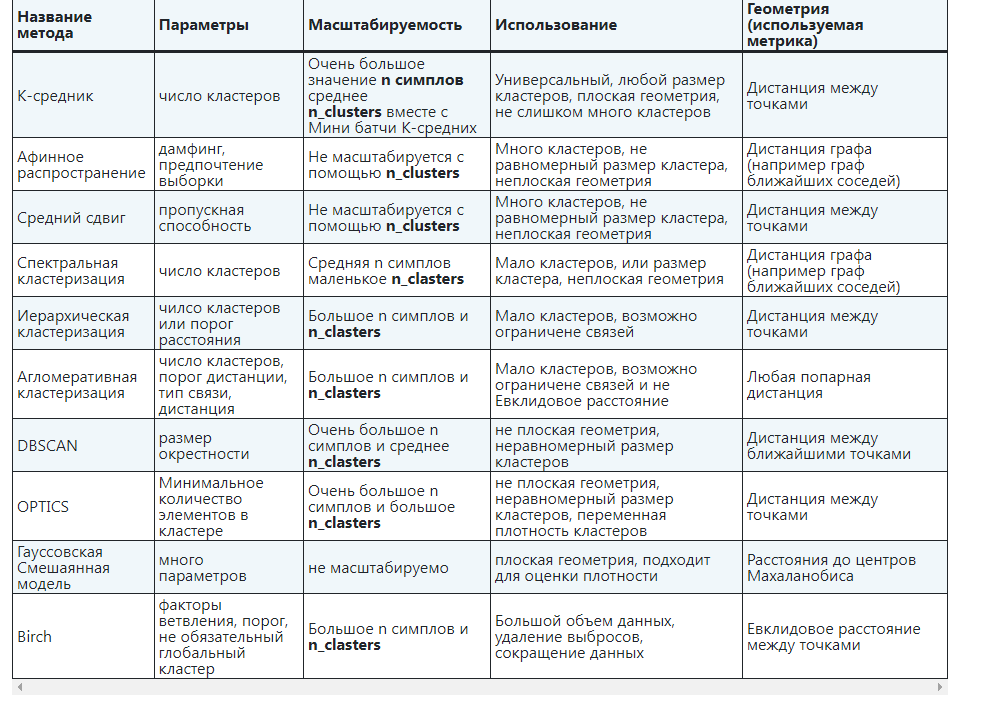

https://scikit-learn.ru/stable/modules/clustering.html#clustering-performance-evaluation

# Определение оптимального количества кластеров
* метод локтя
* с помощью метрики силуэт

Кластеризхация

# 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Данные
df = pd.read_csv('data.csv')
X = df.select_dtypes(include=[np.number]).fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# 1. Метод локтя (Elbow) без цикла
k_range = np.arange(2, 11)
inertias = list(map(lambda k: KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled).inertia_, k_range))

# 2. Метрика силуэта без цикла
silhouette_scores = list(map(lambda k: silhouette_score(X_scaled, KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)), k_range))

# Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_range, inertias, 'bo-'); ax1.set_title('Elbow Method'); ax1.grid(True)
ax2.plot(k_range, silhouette_scores, 'go-'); ax2.set_title('Silhouette Method'); ax2.grid(True)
plt.show()

# Оптимальные значения
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное число кластеров: {best_k_silhouette} (silhouette = {np.max(silhouette_scores):.3f})")

# Кластеризация с оптимальным k
df['cluster'] = KMeans(n_clusters=best_k_silhouette, random_state=42, n_init=10).fit_predict(X_scaled)

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Все алгоритмы сразу
df['kmeans'] = KMeans(n_clusters=3).fit_predict(X_scaled)
df['dbscan'] = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_scaled)
df['agg'] = AgglomerativeClustering(n_clusters=3).fit_predict(X_scaled)

print("Кластеризация готова")

In [ ]:
# Метод локтя
plt.plot([2,3,4,5], [KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in [2,3,4,5]], 'bo-')
plt.show()

In [ ]:
# Оптимальное k через силуэт
k_scores = {k: silhouette_score(X_scaled, KMeans(n_clusters=k).fit_predict(X_scaled)) for k in [2,3,4,5]}
best_k = max(k_scores, key=k_scores.get)
print(f"Оптимально: {best_k} кластеров")